<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-patient-outcome-data" data-toc-modified-id="Plot-patient-outcome-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot patient outcome data</a></span><ul class="toc-item"><li><span><a href="#Overall-response-rate" data-toc-modified-id="Overall-response-rate-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Overall response rate</a></span></li><li><span><a href="#Neurotoxicity" data-toc-modified-id="Neurotoxicity-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Neurotoxicity</a></span></li><li><span><a href="#Hematotoxicity" data-toc-modified-id="Hematotoxicity-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Hematotoxicity</a></span></li><li><span><a href="#CRS" data-toc-modified-id="CRS-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>CRS</a></span></li></ul></li></ul></div>

The notebook reproduces the analysis of clinical efficacy and safety from patient outcome data (Fig. 1).

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import warnings

import os
from os import listdir
from os.path import isfile, join
import sys
import psutil

import anndata
import scanpy.external as sce

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
sc.settings.verbosity = 3

sc.set_figure_params(vector_friendly=True, color_map='Reds',
                     dpi=200,transparent=True, fontsize=14)

palette=['#3519ED','#EDFBA8', '#4D2E6A', '#0ECDB4', '#0C23B5', '#92BF0D', '#51F2E4', '#1CB09D', '#BFC1D4', '#A98BF3', '#98D1C6', '#9A5E72', '#B89327', '#6704A5', '#0F64B2', '#A69CF3', '#D97C2E',
        '#321795', '#7E2649', '#65A813', '#734E0F', '#D14FBC', '#2CFA50', '#83610A', '#841032', '#04D8E3', '#8605BA', '#1EF60C', '#602587', '#F9AD1B', '#2BD738', '#C8E239', '#46D1BC',
        '#465A01', '#70C51E', '#924DFB', '#5D28E4', '#712E8D', '#30F465', '#5287E1', '#D16B7F', '#B8EF72', '#03B15D', '#4290F3', '#5E9063', '#B0E39F', '#3C6205', '#ACE603', '#2DE57A',
         '#052B18', '#69BE75', '#8BE509', '#C37041', '#E218BA', '#5AC097', '#A597C4','#2A13B5', '#823FA7', '#C8F349', '#7C482A', '#A104E5', '#8E3C27', '#1DB457', '#36FDC7', '#60A934', '#F43B78',
        '#74EF61', '#810527', '#6D293F', '#F1A709', '#274F6C', '#104EB5', '#6D02CE', '#B36AE5', '#13F9BA', '#C7281F', '#31572B', '#07D94B', '#B45E18', '#9F73D1', '#3CA059', '#4D6B1C', 
        '#3BA785', '#E3084C', '#A61BF4', '#F3D50A', '#640A32', '#FB0D73', '#AD0126', '#279136', '#480EB1', '#634158', '#FD80E5', '#CF26AE', '#046DB9', '#15F6B8', '#1A047C', '#D14826', 
        '#45D160', '#C6039B', '#D9C23F', '#70829B', '#940ECF', '#9FAB37', '#BA84C7', '#68F275', '#C79EA1', '#6E89B7', '#712D6C', '#F51D8C', '#D564E0', '#24EA18', '#459C71', '#23F50B', 
        '#3E57C8', '#6D78F9', '#07EC9F', '#3078C5', '#53EC0A','#D283E5', '#16039B', '#61E0A8', '#10A659', '#52374A', '#B31EC4', '#254D10', '#D5B0F4', '#A79E35', '#2D0F45', '#562D18', 
        '#ABE562', '#9A0842', '#92165C', '#FCD98A', '#B384DA', '#3CB108', '#2FE04C', '#386CA2', '#423719', '#E540C2', '#C58DE9', '#F6B8E4','#87592B', '#94D53F', '#4AB5E3', '#B0E96C',
        '#AD94E6', '#E237B8', '#21F0B9', '#FB9C73']


# Plot patient outcome data

In [3]:
clinical_data=pd.read_excel('/path/to/data/mmc4.xlsx')

In [5]:
clinical_data_sub=clinical_data[['Tumor entity', 'NCT Number','ORR', 'CRS rate ', 'Severe CRS rate', 'Neuro Rate ', 'Hematotox Rate']]


In [6]:
entities_of_interest=['Multiple Myeloma','Follicular B cell lymphoma','Acute Lymphoblastic Leukemia',
                      'Large B-cell Lymphoma & Diffuse Large B-cell Lymphoma & Primary mediastinal B-cell lymphoma',
                     'Mantle Cell Lymphoma']

In [7]:
clinical_data_sub=clinical_data_sub[np.isin(clinical_data_sub['Tumor entity'], entities_of_interest)]

In [8]:
clinical_data_sub['Tumor entity']=clinical_data_sub['Tumor entity'].replace({'Mantle Cell Lymphoma':'Large B-cell Lymphoma & Diffuse Large B-cell Lymphoma & Primary mediastinal B-cell lymphoma'})




In [10]:
clinical_data_sub['entity_gene']=clinical_data_sub['Tumor entity']+str('_')+clinical_data_sub['NCT Number']

In [12]:
clinical_data_sub.head()

,Tumor entity,NCT Number,ORR,CRS rate,Severe CRS rate,Neuro Rate,Hematotox Rate,entity_gene
0,Multiple Myeloma,BCMA,0.333333,0.416667,0.166667,0.083333,0.270833,Multiple Myeloma_BCMA
1,Multiple Myeloma,BCMA,0.680000,0.880000,0.320000,0.320000,0.084800,Multiple Myeloma_BCMA
2,Multiple Myeloma,BCMA,0.848485,0.757576,0.060606,0.424242,0.084481,Multiple Myeloma_BCMA
3,Multiple Myeloma,BCMA,0.989474,0.948454,0.041237,0.206186,0.038261,Multiple Myeloma_BCMA
4,Multiple Myeloma,BCMA,0.746032,0.835938,0.054688,0.179688,0.022949,Multiple Myeloma_BCMA


In [14]:
#remove CD7 (B-ALL) as this is rather for T-ALL
clinical_data_sub=clinical_data_sub[clinical_data_sub.entity_gene != 'Acute Lymphoblastic Leukemia_CD7']

In [15]:
neworder=['Follicular B cell lymphoma_CD19','Multiple Myeloma_CD19','Acute Lymphoblastic Leukemia_CD19',
          'Large B-cell Lymphoma & Diffuse Large B-cell Lymphoma & Primary mediastinal B-cell lymphoma_CD19',
          
          'Multiple Myeloma_BCMA', 
          'Large B-cell Lymphoma & Diffuse Large B-cell Lymphoma & Primary mediastinal B-cell lymphoma_BCMA',
          
          'Multiple Myeloma_GPRC5D', 'Multiple Myeloma_SLAMF7',
          'Acute Lymphoblastic Leukemia_CD22']

name_order = {nm:ix for ix,nm in enumerate(neworder)}

In [16]:
clinical_data_sub=clinical_data_sub.sort_values(by='entity_gene', key=lambda nm: nm.map(name_order))

In [17]:
sb.set(rc={'figure.figsize':(12,8)})

In [18]:
sb.set_style("white")

## Overall response rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


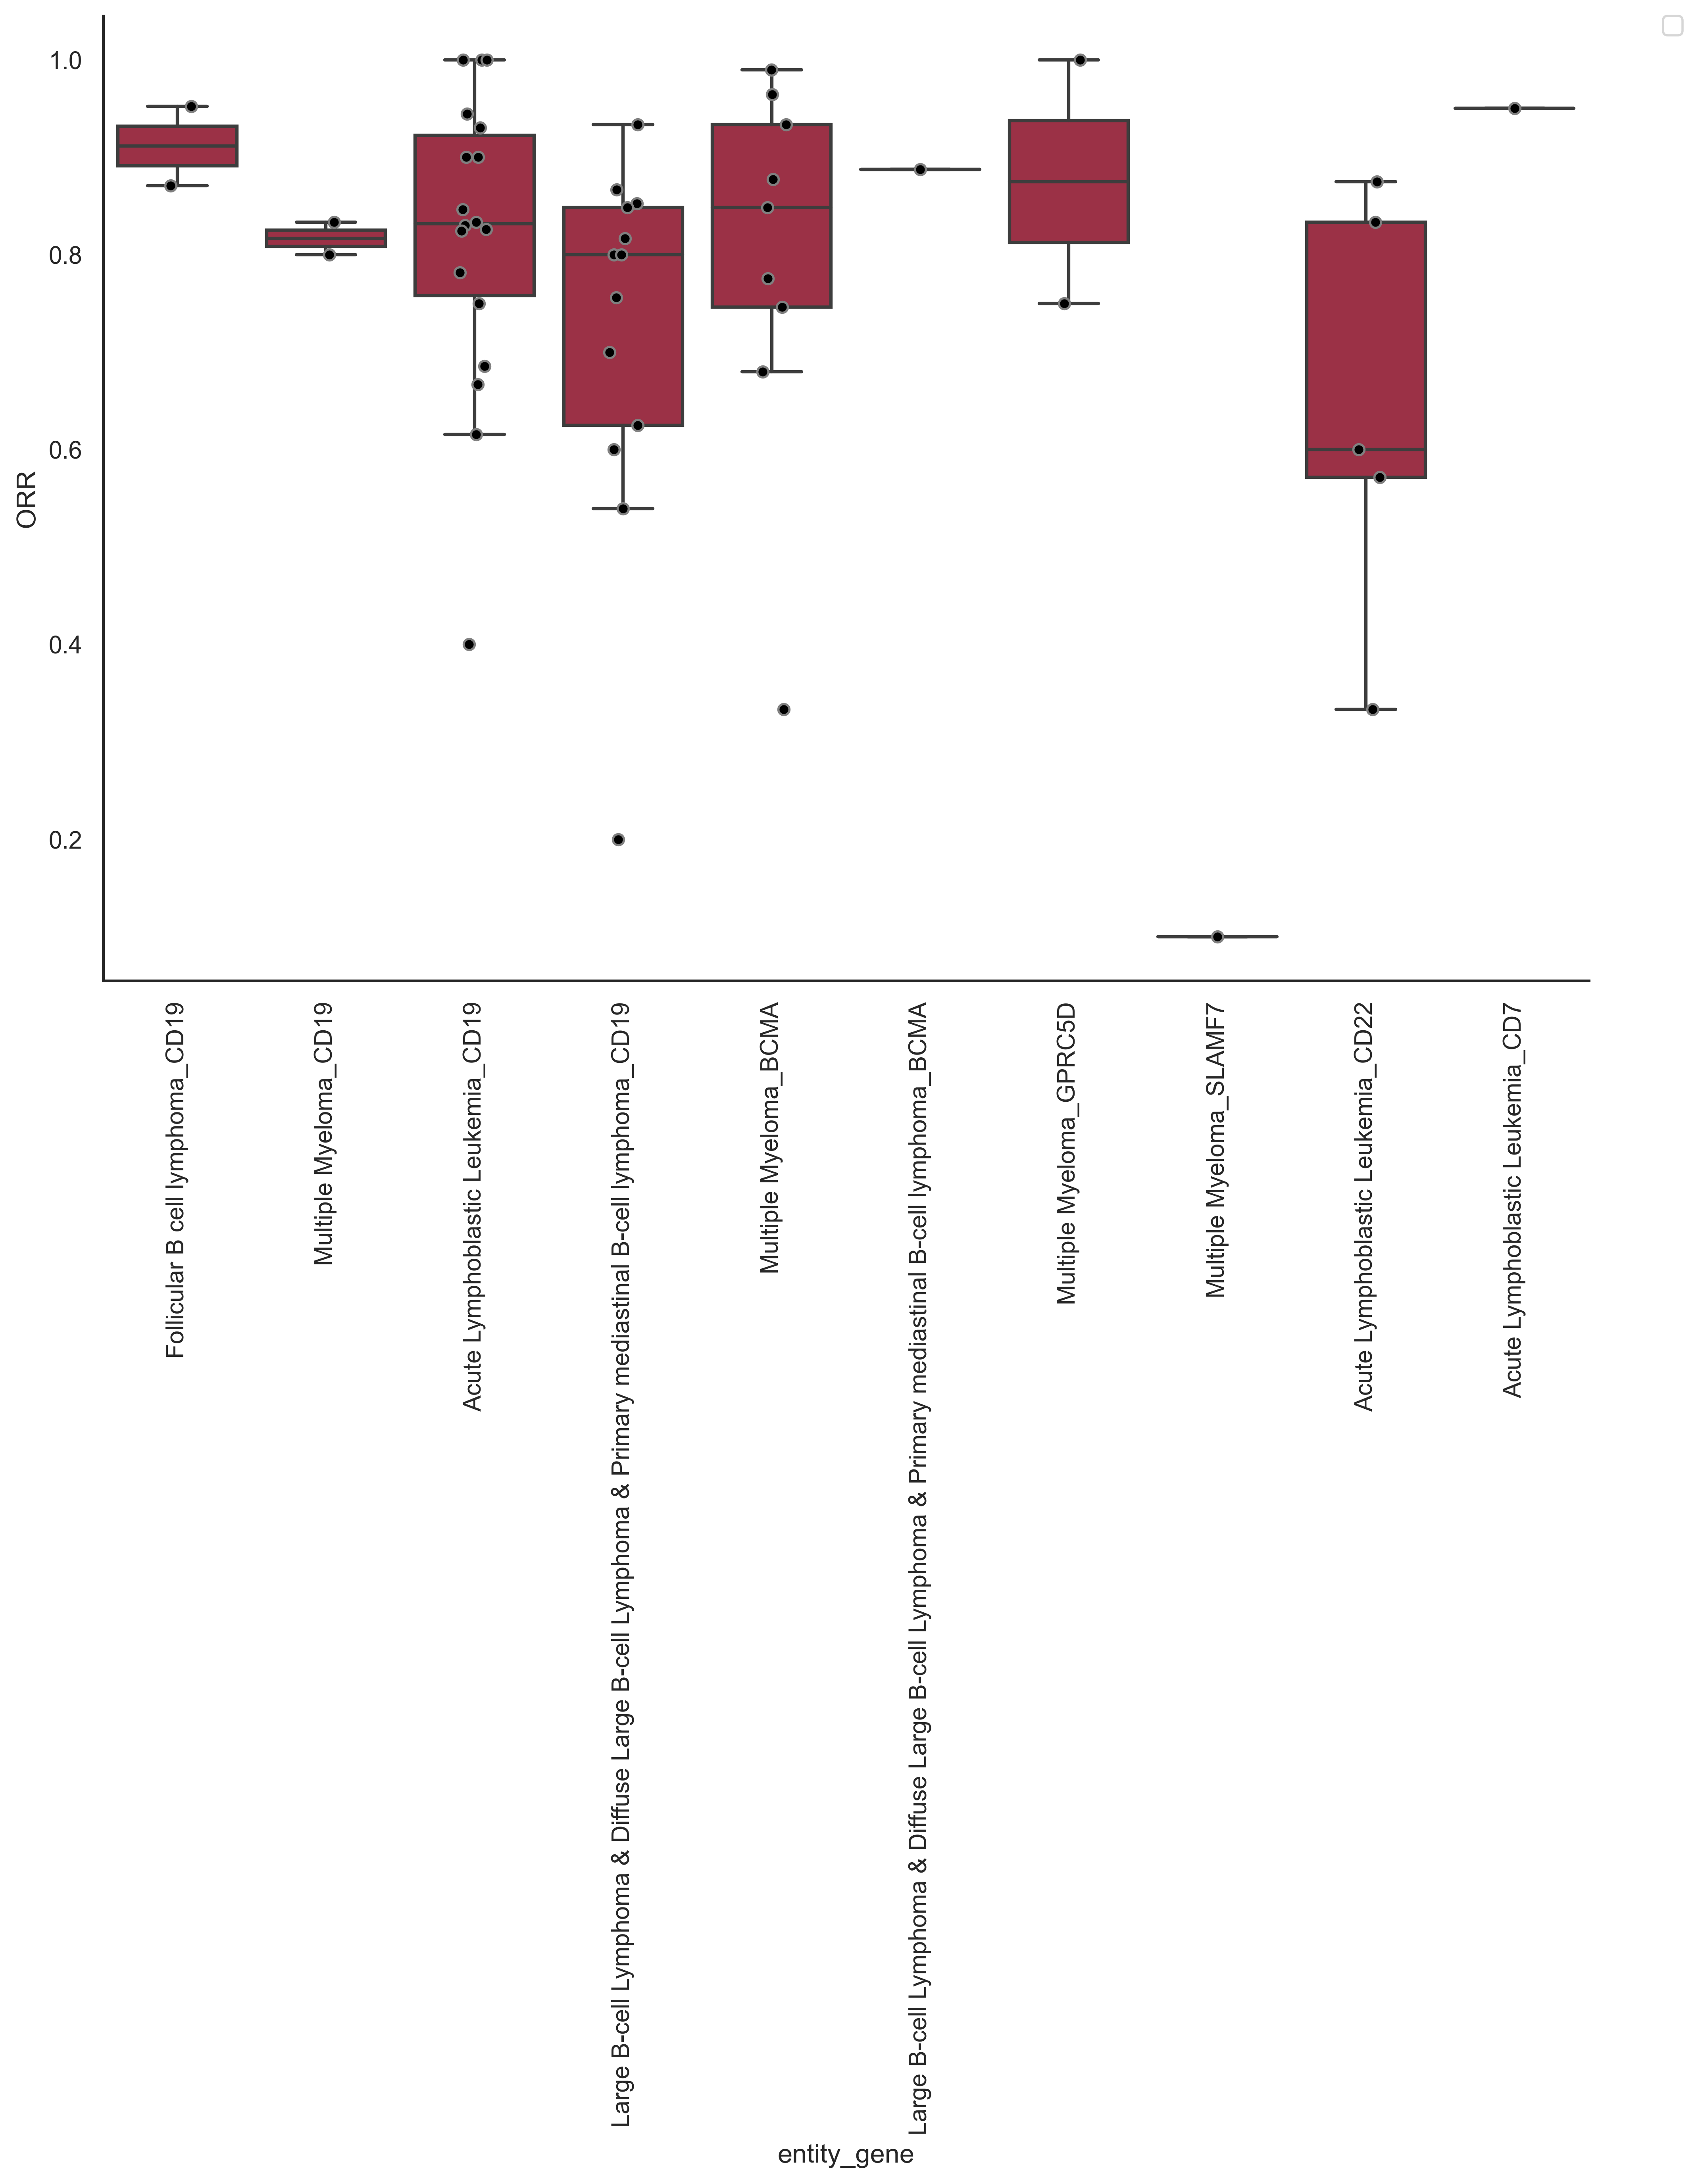

In [308]:
plot=sb.stripplot(data=clinical_data_sub, x="entity_gene", y="ORR",
             jitter=True,
             color="black",
             linewidth=1,
             edgecolor='grey'
            )

sb.boxplot(x="entity_gene", y="ORR", color='#ad1f3c',data=clinical_data_sub,fliersize=0)
sb.despine()
plt.setp(plot.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Neurotoxicity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


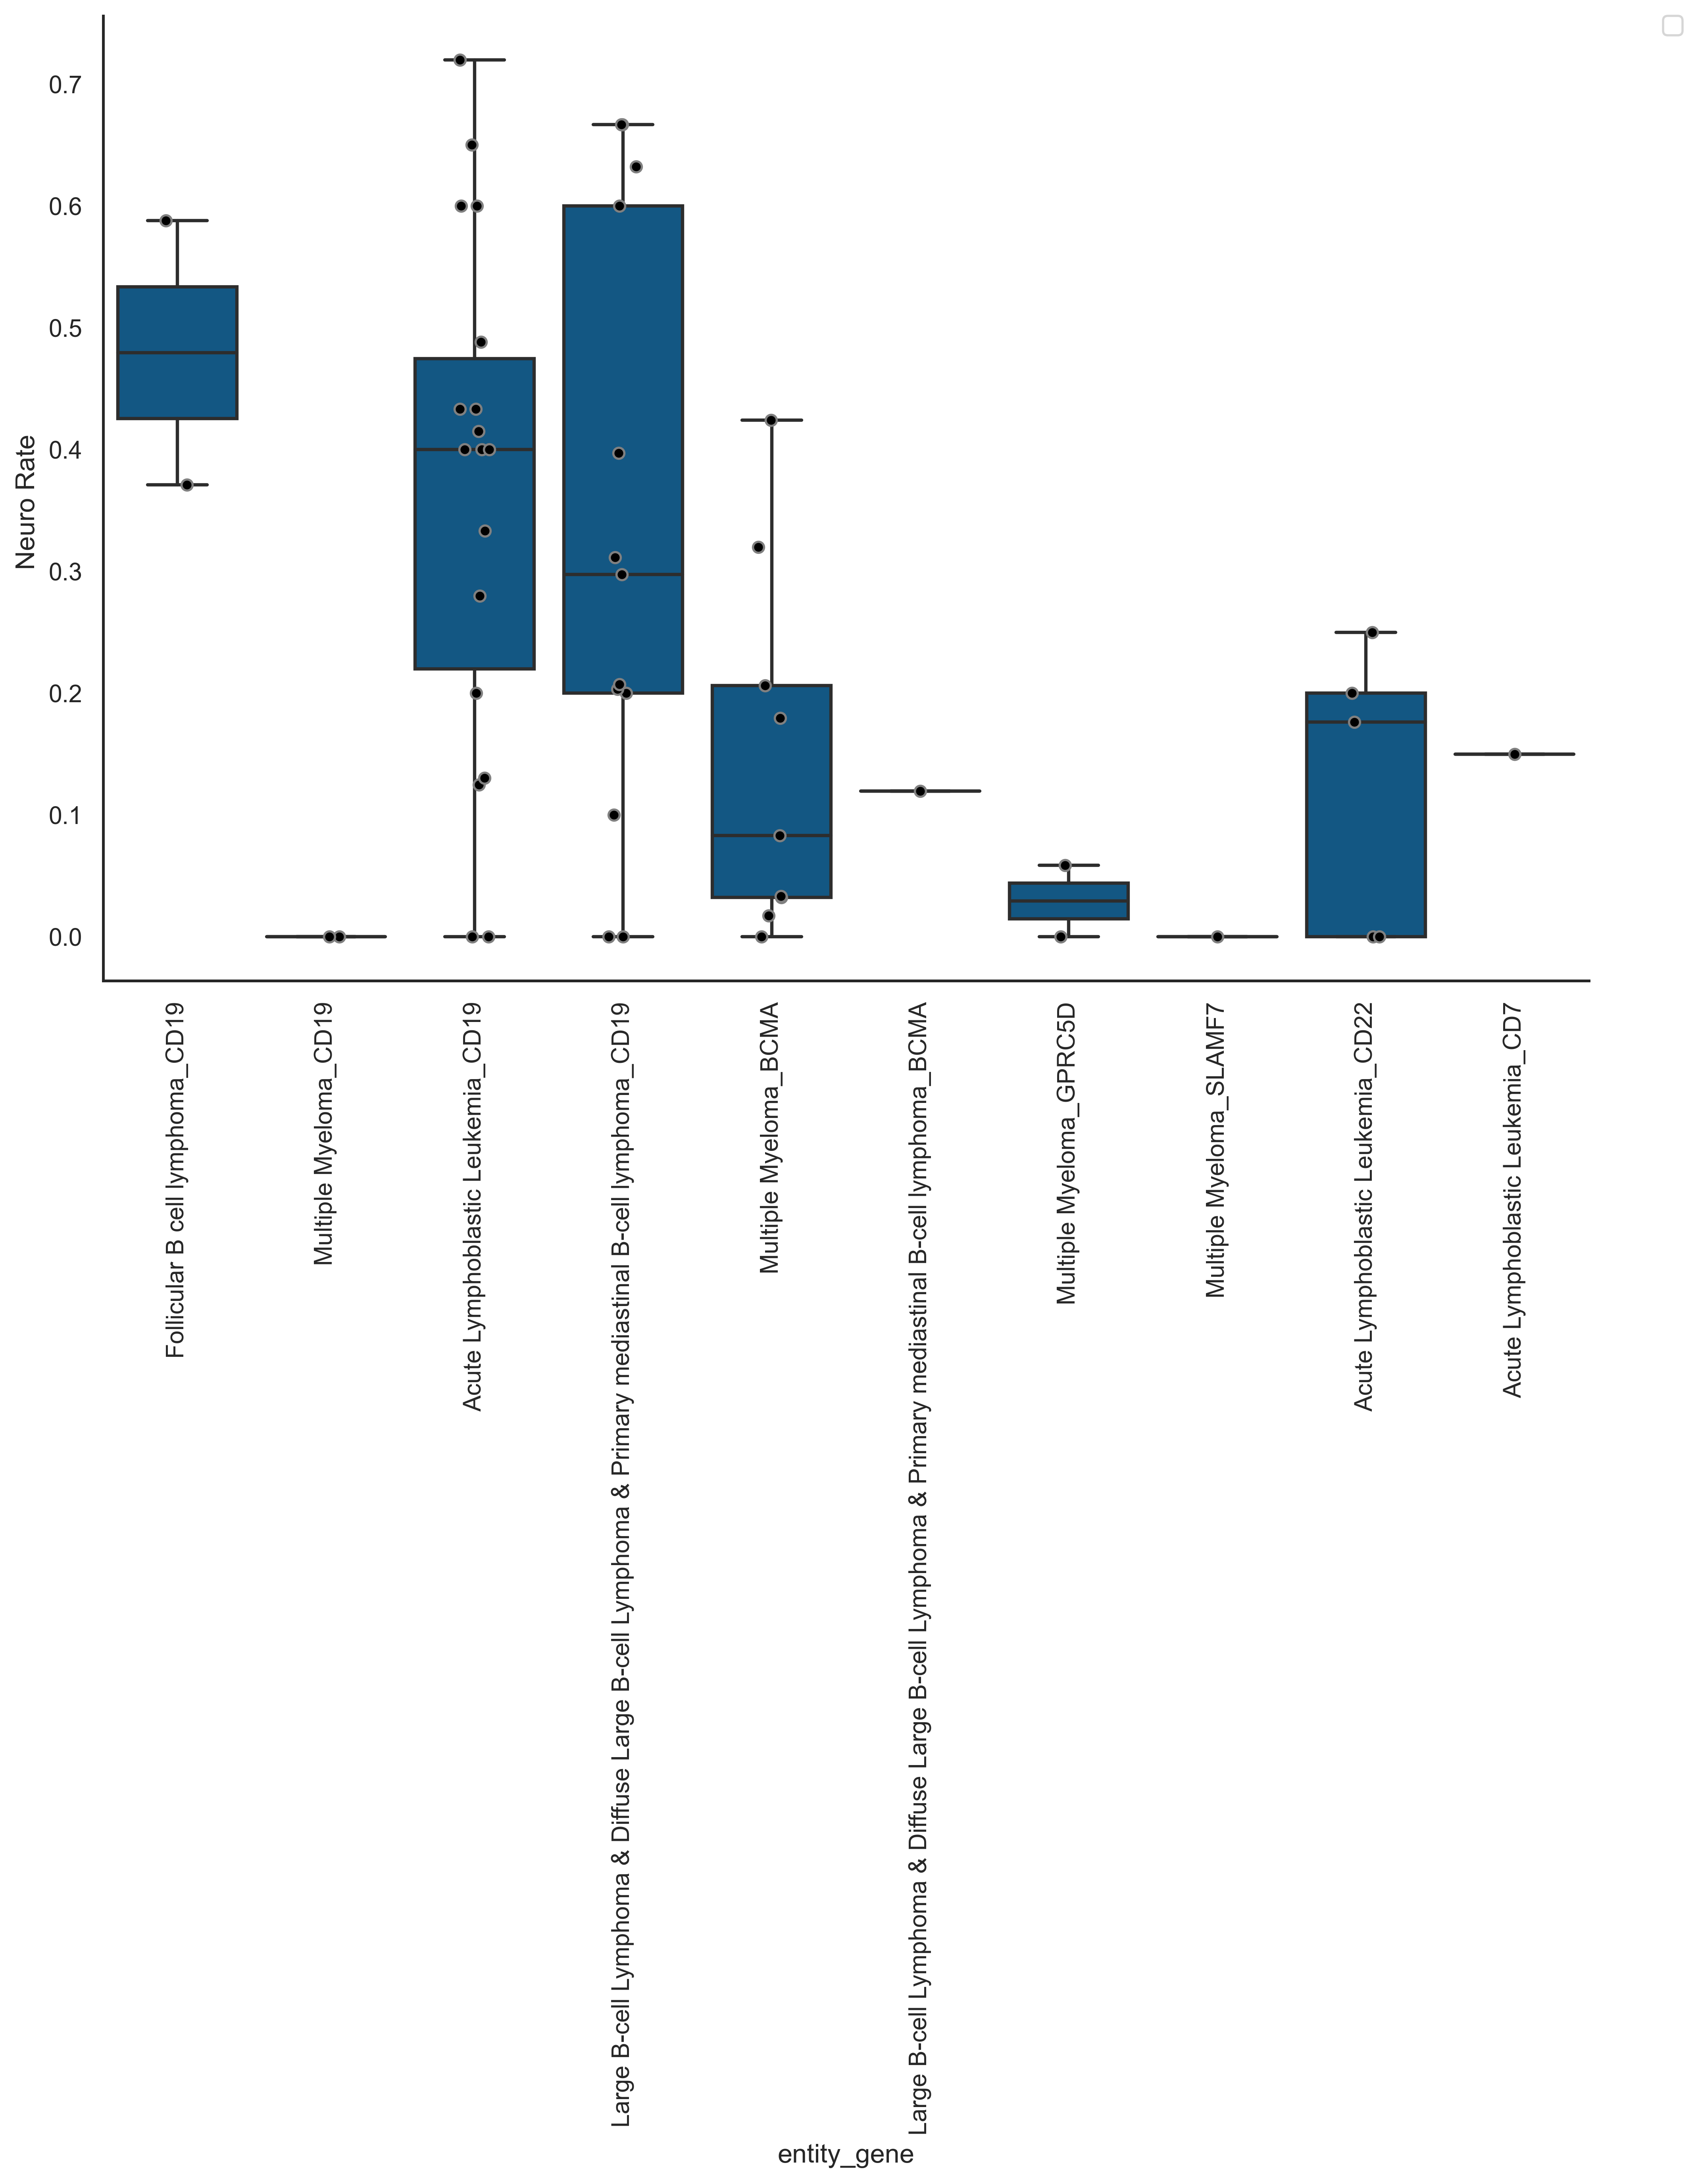

In [309]:
plot=sb.stripplot(data=clinical_data_sub, x="entity_gene", y="Neuro Rate ",
             jitter=True,
             color="black",
             linewidth=1,
             edgecolor='grey'
            )

sb.boxplot(x="entity_gene", y="Neuro Rate ", color='#005b96',data=clinical_data_sub,fliersize=0)
sb.despine()
plt.setp(plot.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Hematotoxicity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


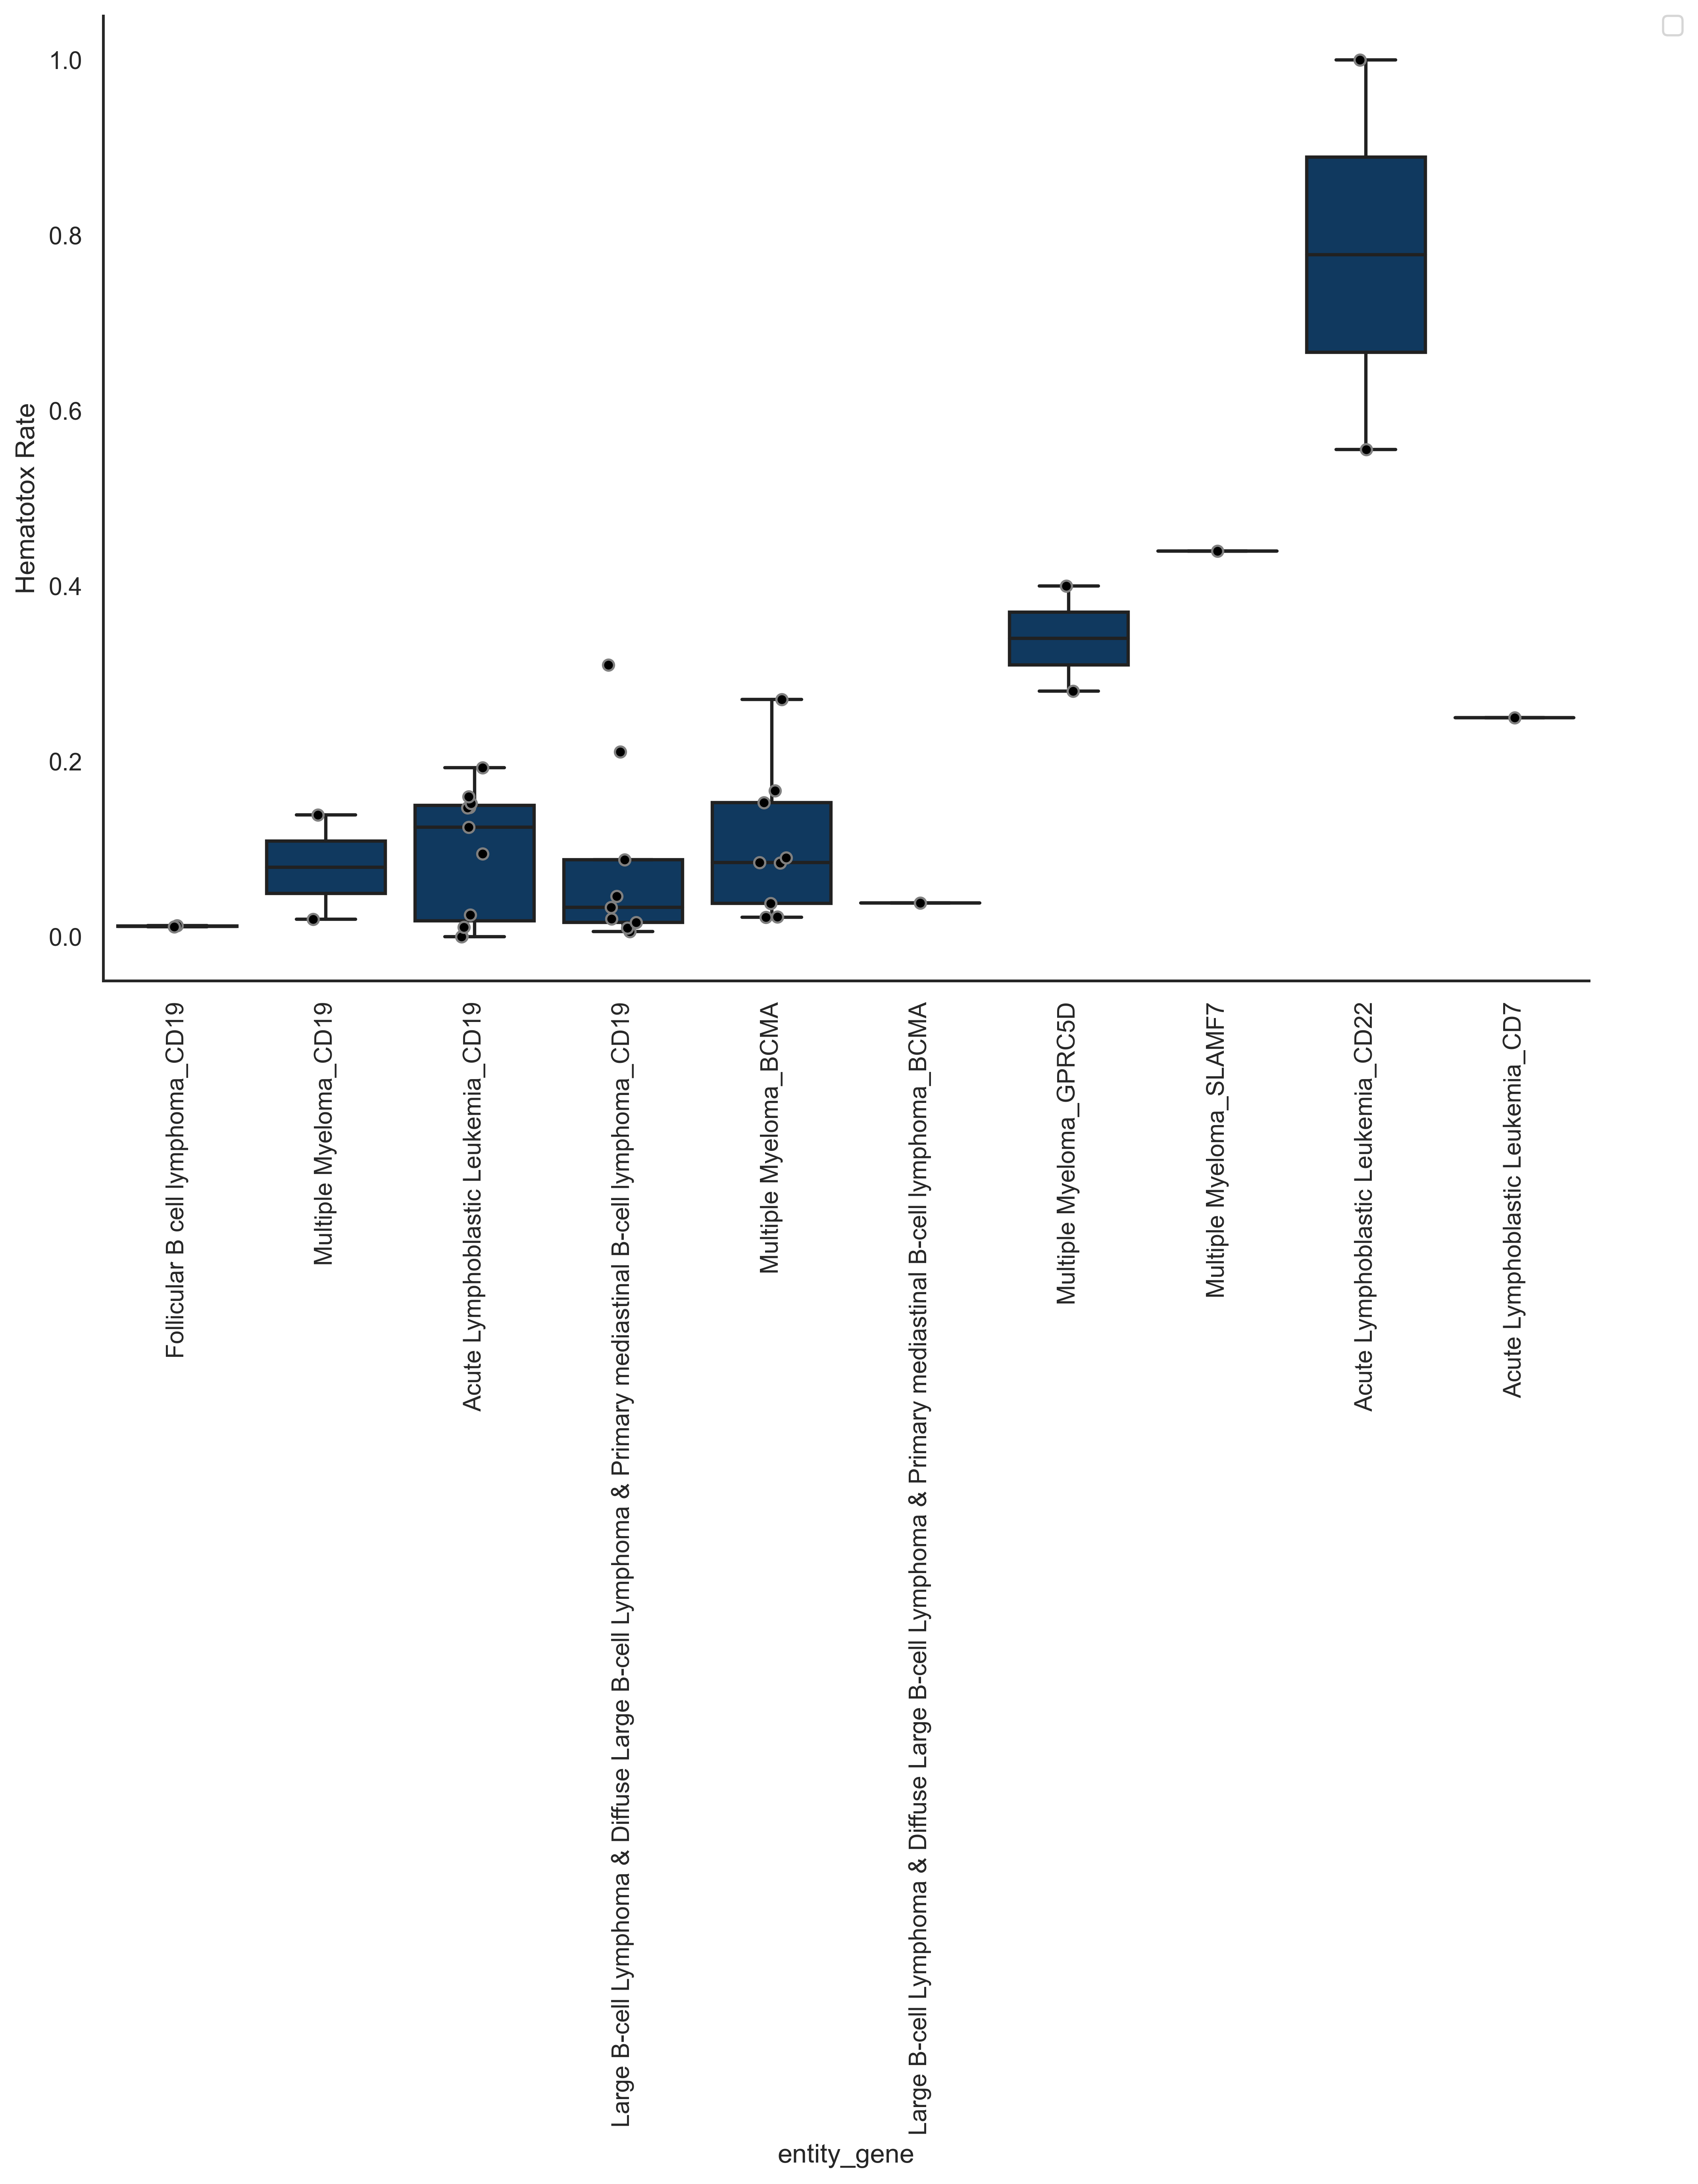

In [310]:
plot=sb.stripplot(data=clinical_data_sub, x="entity_gene", y="Hematotox Rate",
             jitter=True,
             color="black",
             linewidth=1,
             edgecolor='grey'
            )

sb.boxplot(x="entity_gene", y="Hematotox Rate", color='#03396c',data=clinical_data_sub,fliersize=0)
sb.despine()
plt.setp(plot.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## CRS

In [311]:
clinical_data_sub_crs=clinical_data_sub[['entity_gene','CRS rate ', 'Severe CRS rate']]
clinical_data_sub_crs.head()

,entity_gene,CRS rate,Severe CRS rate
15,Follicular B cell lymphoma_CD19,0.484536,0.000000
14,Follicular B cell lymphoma_CD19,0.817568,0.067568
12,Multiple Myeloma_CD19,0.100000,0.000000
11,Multiple Myeloma_CD19,0.166667,0.000000
57,Acute Lymphoblastic Leukemia_CD19,0.230769,0.000000


In [312]:
data = clinical_data_sub_crs.melt(id_vars=['entity_gene'], var_name='dataset', value_name='values')

In [316]:
my_pal = {"CRS rate ": "#b3cde0", "Severe CRS rate": "#43728a"}

/Users/moritz.thomas/miniconda3/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


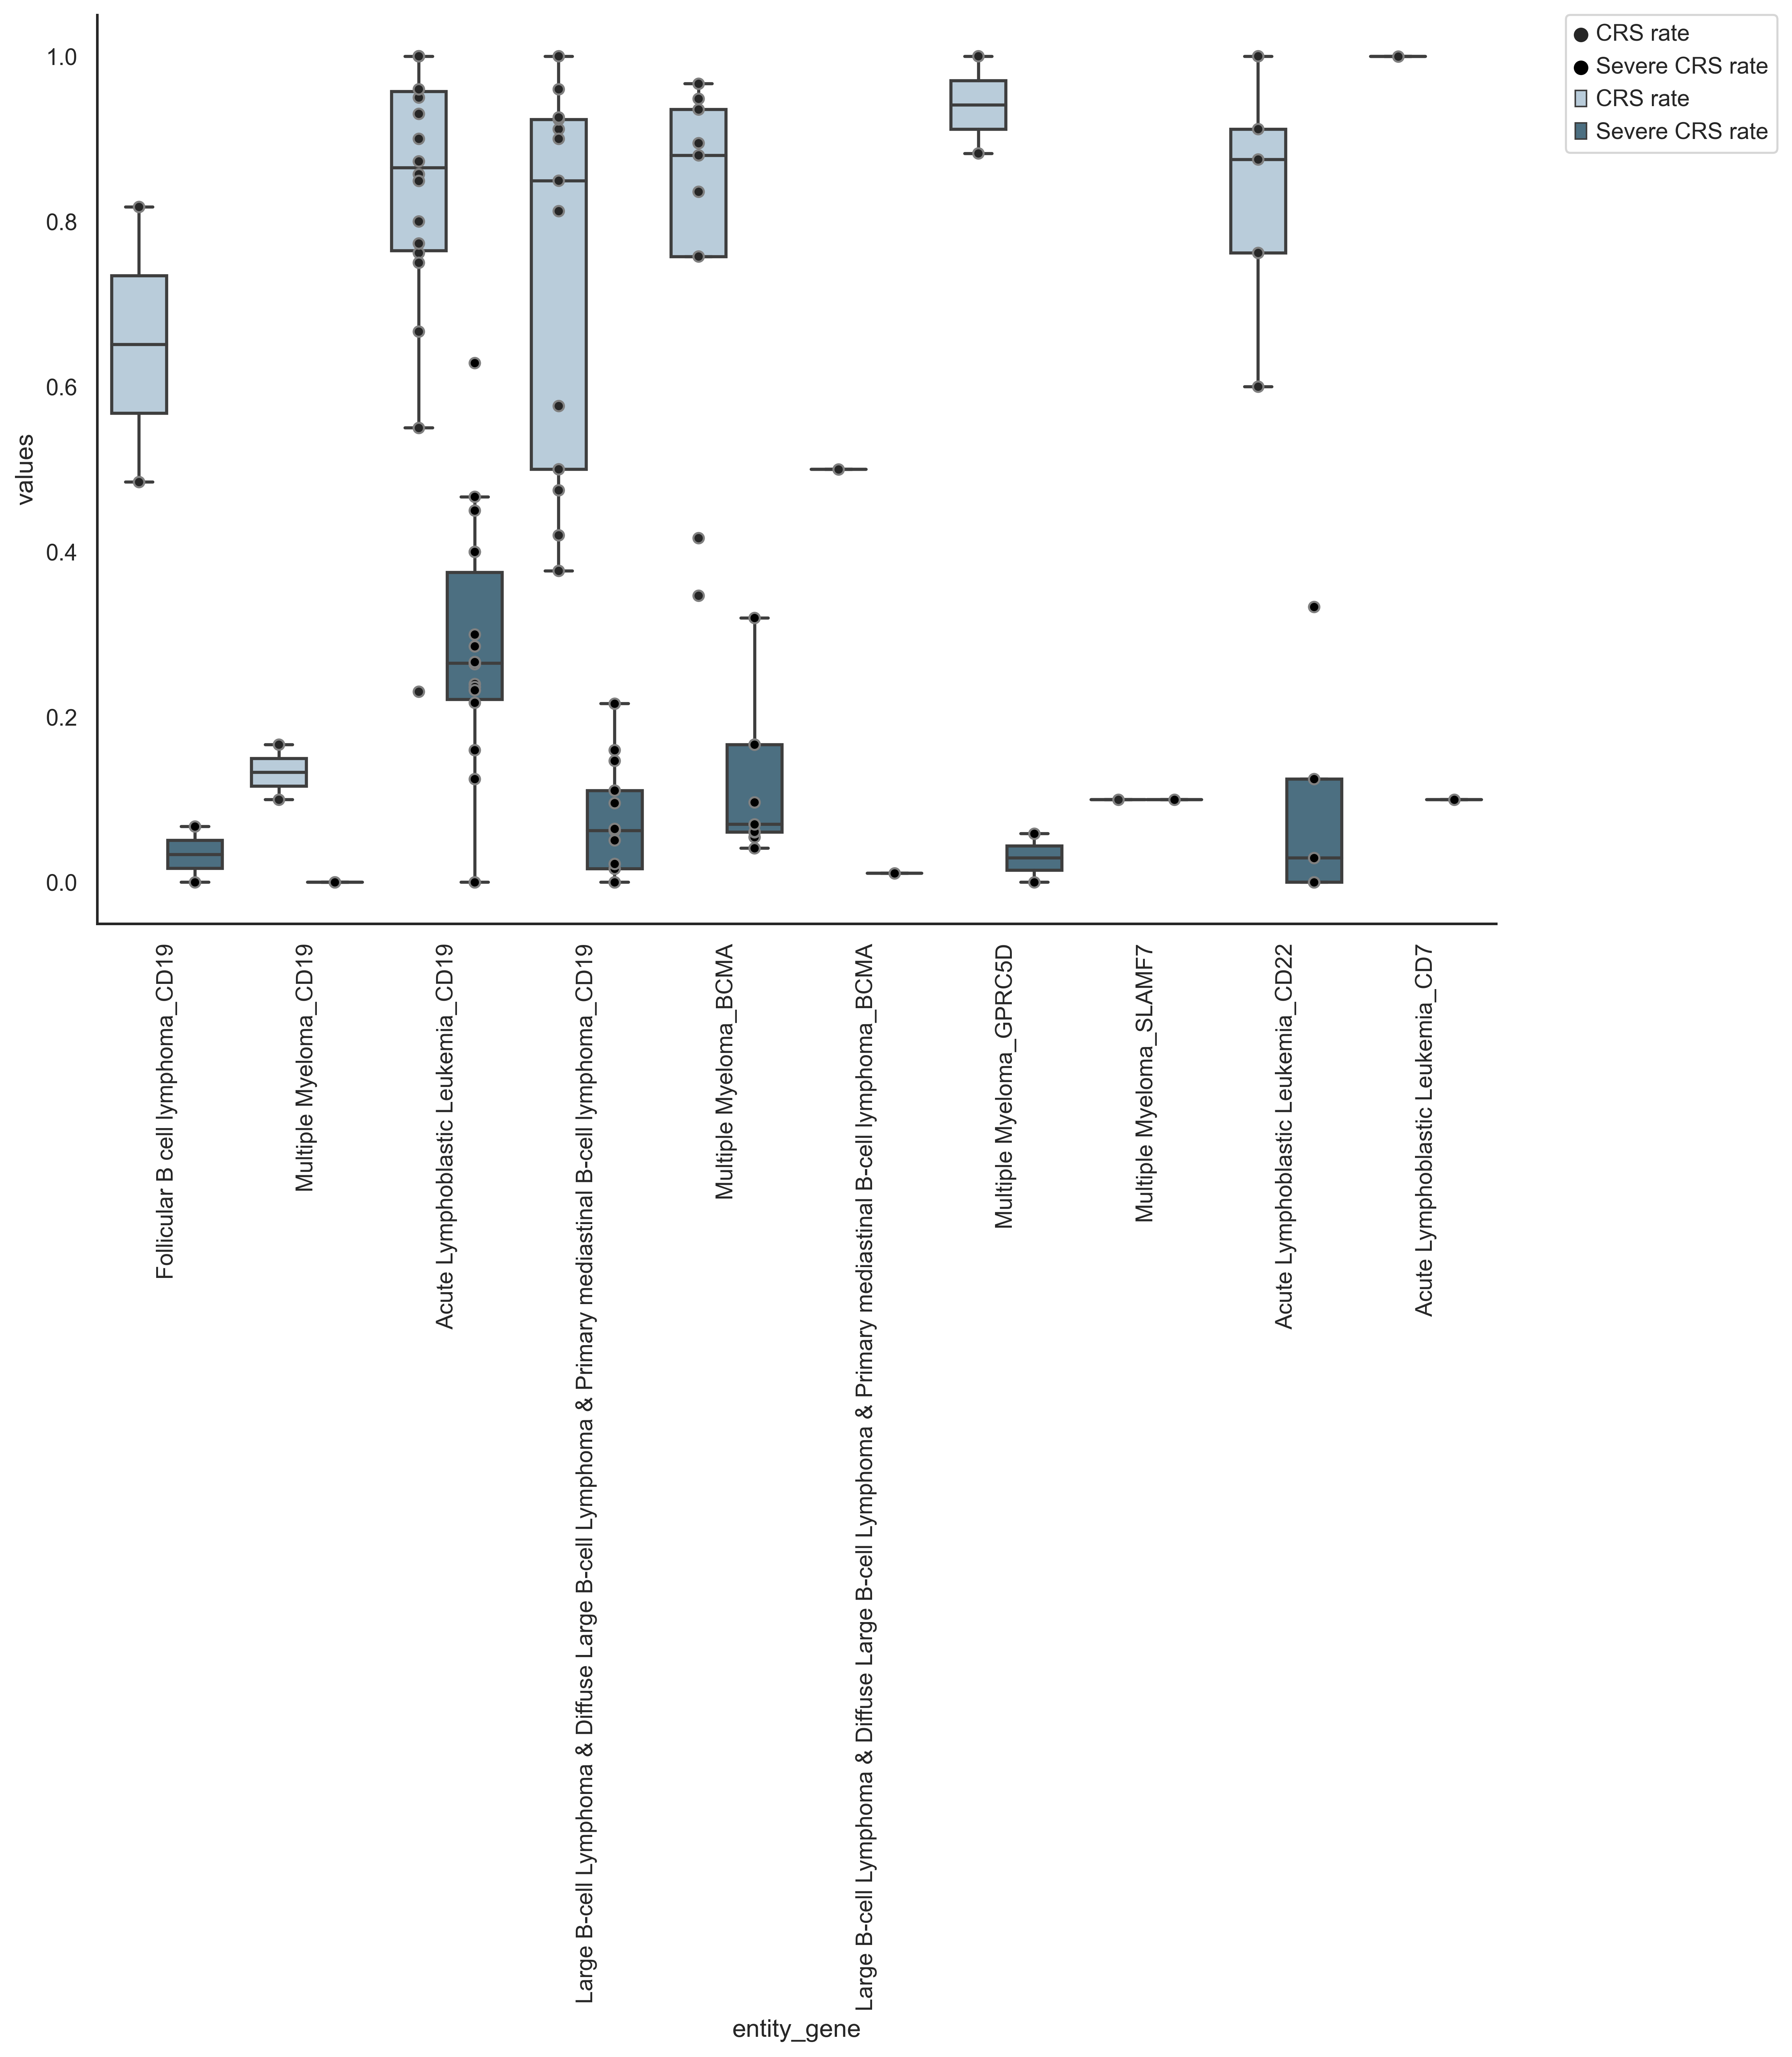

In [317]:
plot=sb.stripplot(data=data, x="entity_gene", y="values",
             jitter=False,
                  hue='dataset',
                  dodge=True,
             color="black",
             linewidth=1,
             edgecolor='grey'
            )

sb.boxplot(x="entity_gene", y="values", 
           hue='dataset',
           palette=my_pal,
           data=data,
           fliersize=0)
sb.despine()
plt.setp(plot.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)